In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
base_dataset_dir = "E:\Major Project 2022\Dataset"
csv_path = base_dataset_dir+"\\"+"64by64_Dataset_RBG.csv"

In [3]:
image_df = pd.read_csv(csv_path)

image_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,Label
8839,6,1,22,6,1,20,6,1,21,6,...,62,49,83,55,45,74,55,53,88,4
1035,14,7,11,19,10,11,23,13,14,53,...,124,103,112,101,84,92,97,77,84,1
4992,0,1,5,0,1,5,0,1,6,0,...,194,169,151,196,174,160,193,164,144,2
5506,146,87,86,142,88,88,138,85,84,133,...,133,89,78,135,90,80,136,90,81,2
469,138,111,99,140,110,97,139,110,96,142,...,16,8,5,13,6,3,11,6,3,0


In [4]:
image_df_copy = image_df.copy()

label = image_df_copy.pop("Label")

X = np.array(image_df_copy)

X.shape , label.shape

((16431, 12288), (16431,))


Scaling and Split Data into Train, Validation and Test set


In [5]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [6]:
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11829, 12288), (2958, 12288), (1644, 12288), (11829,), (2958,), (1644,))


Reshape


In [7]:
X_train = X_train.reshape(X_train.shape[0], *(64, 64, 3))
X_val = X_val.reshape(X_val.shape[0], *(64, 64, 3))
X_test = X_test.reshape(X_test.shape[0], *(64, 64, 3))

X_train.shape, X_val.shape, X_test.shape

((11829, 64, 64, 3), (2958, 64, 64, 3), (1644, 64, 64, 3))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

y_train.shape, y_val.shape, y_test.shape

((11829, 8), (2958, 8), (1644, 8))

# # CNN Model using Tensorflow

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape = (64, 64, 3))) # Check -- its not input()-- Input() is used to instantiate a Keras tensor

    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(8 , activation = 'softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer = 'adam', 
        metrics = ['accuracy']
        )

    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 64)       

In [16]:
h = model.fit(
    X_train/225., y_train,
    validation_data = (X_val/225., y_val),
    epochs = 30, batch_size = 64,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3),
                 tf.keras.callbacks.ModelCheckpoint(
                     '/content/models/model_{val_accuracy:.3f}.h5', save_best_only = True,
                      save_weights_only = False, moniter = 'val_accuracy'
                                                    )
                 ]
              )

Epoch 1/30
185/185 [==============================] - 229s 907ms/step - loss: 2.2849 - accuracy: 0.2649 - val_loss: 2.0336 - val_accuracy: 0.2397
Epoch 2/30
185/185 [==============================] - 147s 794ms/step - loss: 1.8480 - accuracy: 0.3190 - val_loss: 2.1187 - val_accuracy: 0.2397
Epoch 3/30
185/185 [==============================] - 149s 804ms/step - loss: 1.7960 - accuracy: 0.3431 - val_loss: 1.9348 - val_accuracy: 0.2410
Epoch 4/30
185/185 [==============================] - 155s 834ms/step - loss: 1.7539 - accuracy: 0.3557 - val_loss: 1.8315 - val_accuracy: 0.3144
Epoch 5/30
185/185 [==============================] - 149s 806ms/step - loss: 1.7166 - accuracy: 0.3775 - val_loss: 1.7497 - val_accuracy: 0.3563
Epoch 6/30
185/185 [==============================] - 148s 798ms/step - loss: 1.6859 - accuracy: 0.3865 - val_loss: 1.6999 - val_accuracy: 0.3807
Epoch 7/30
185/185 [==============================] - 149s 807ms/step - loss: 1.6726 - accuracy: 0.3951 - val_loss: 1.7143 -

In [18]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("Baseline_model_1.h5")

93/93 [==============================] - 12s 128ms/step - loss: 711.9855 - accuracy: 0.1924
Validation: accuracy = 0.192360  ;  loss_v = 711.985535
Test: accuracy = 0.190998  ;  loss = 686.578613


Text(0.5, 1.0, 'Training and validation loss')

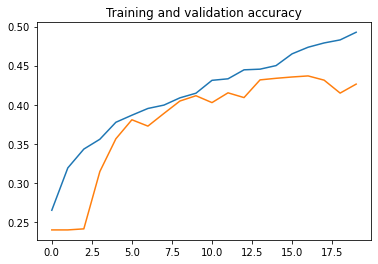

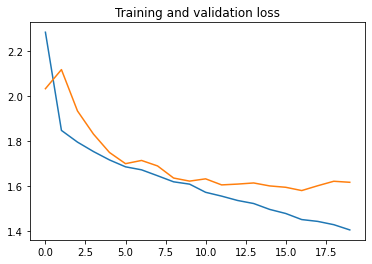

In [25]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = h.history['accuracy']
val_acc = h.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = h.history['loss']
val_loss = h.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc , label = 'Training')
plt.plot(epochs, val_acc , label = 'Validation')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss , label = 'Training Loss')
plt.plot(epochs, val_loss , label = 'Validation Loss')
plt.title('Training and validation loss')


# Model 2 


In [26]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(8, activation='softmax')(x)

# Configure and compile the model
model_2 = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_2.summary()


C:\Users\DELL\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496 

In [27]:
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [29]:
batch_size = 64
epochs = 30
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\DELL\AppData\Local\Temp/ipykernel_13128/3666111815.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30
184/184 [==============================] - 211s 789ms/step - loss: 1.8121 - accuracy: 0.3412 - val_loss: 1.6735 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 2/30
184/184 [==============================] - 156s 847ms/step - loss: 1.7541 - accuracy: 0.3610 - val_loss: 1.6909 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 3/30
184/184 [==============================] - 153s 831ms/step - loss: 1.7266 - accuracy: 0.3756 - val_loss: 1.6693 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 4/30
184/184 [==============================] - 153s 831ms/step - loss: 1.7167 - accuracy: 0.3817 - val_loss: 1.6057 - val_accuracy: 0.4118 - lr: 0.0010
Epoch 5/30
184/184 [==============================] - 163s 884ms/step - loss: 1.7073 - accuracy: 0.3835 - val_loss: 1.6001 - val_accuracy: 0.4222 - lr: 0.0010
Epoch 6/30
184/184 [==============================] - 183s 998ms/step - loss: 1.6838 - accuracy: 0.3909 - val_loss: 1.6424 - val_accuracy: 0.4124 - lr: 0.0010
Epoch 7/30
184/184 [==========================

184/184 [==============================] - 206s 1s/step - loss: 1.6142 - accuracy: 0.4204 - val_loss: 1.6087 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 22/30
184/184 [==============================] - 206s 1s/step - loss: 1.6099 - accuracy: 0.4202 - val_loss: 1.5751 - val_accuracy: 0.4344 - lr: 0.0010
Epoch 23/30
184/184 [==============================] - 204s 1s/step - loss: 1.5995 - accuracy: 0.4273 - val_loss: 1.6090 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 24/30
184/184 [==============================] - 202s 1s/step - loss: 1.5906 - accuracy: 0.4250 - val_loss: 1.5523 - val_accuracy: 0.4408 - lr: 0.0010
Epoch 25/30
184/184 [==============================] - 204s 1s/step - loss: 1.5954 - accuracy: 0.4289 - val_loss: 1.6362 - val_accuracy: 0.4236 - lr: 0.0010
Epoch 26/30
184/184 [==============================] - 205s 1s/step - loss: 1.5996 - accuracy: 0.4286 - val_loss: 1.6140 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 27/30
184/184 [==============================] - 206s 1s/step - 

In [30]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("Baseline_model_2.h5")

93/93 [==============================] - 13s 136ms/step - loss: 1.6991 - accuracy: 0.4151
Validation: accuracy = 0.415145  ;  loss_v = 1.699134
Test: accuracy = 0.433698  ;  loss = 1.689691


Text(0.5, 1.0, 'Training and validation loss')

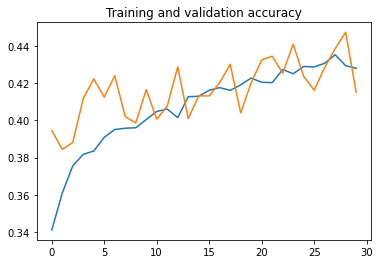

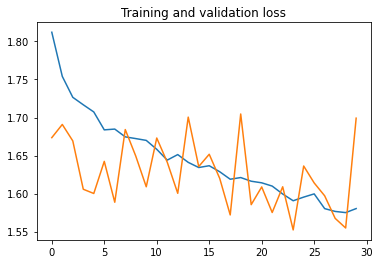

In [32]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')